# Recreating the Heatmap graph from Masslin2

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

--- Generating Heatmap from MaAsLin2 Results (Custom Taxa Order) ---
Successfully loaded MaAsLin2 results: Maaslin2/Maaslin2_outputs/20250609_output_inflammation_necrosis_deInvasion_random_season-state/all_results.tsv
Found 10 significant associations to plot.
Placing 'Necrosis' column first.
Heatmap matrix created with shape: (10, 2)

Heatmap plot saved to 'maaslin2_associations_heatmap_custom_order.png'


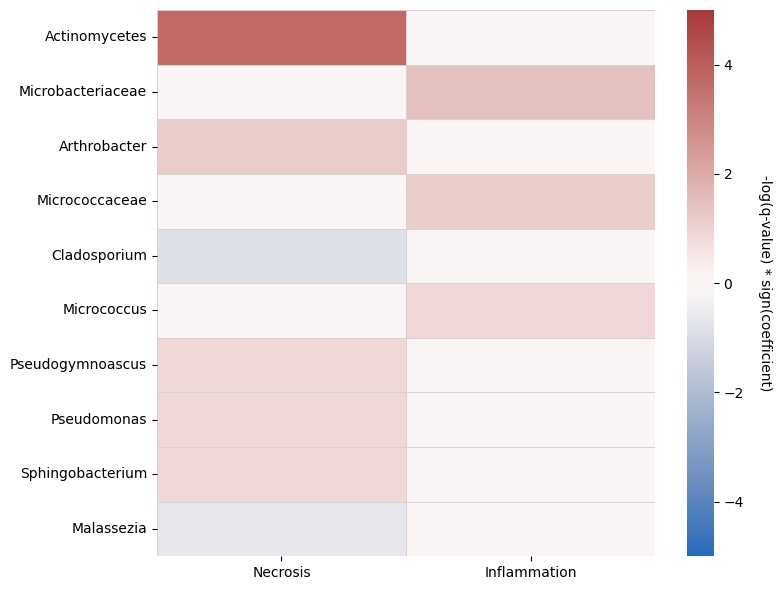

--- Heatmap generation finished ---


In [8]:
def plot_maaslin2_heatmap(
    maaslin2_results_path,
    output_plot_path="maaslin2_heatmap.png",
    q_value_threshold=0.25 # MaAsLin2 default significance threshold
):
    """
    Reads a MaAsLin2 results file, calculates a composite significance score,
    and generates a heatmap to visualize the associations with a custom
    y-axis (taxa) order.

    Args:
        maaslin2_results_path (str): Path to the MaAsLin2 results file 
                                     (e.g., 'all_results.tsv' or 'significant_results.tsv').
        output_plot_path (str): Path to save the generated heatmap plot.
        q_value_threshold (float): FDR-corrected p-value (q-value) threshold to
                                   filter for significant associations to plot.
    """
    print("--- Generating Heatmap from MaAsLin2 Results (Custom Taxa Order) ---")

    # 1. Load MaAsLin2 results data
    try:
        df_results = pd.read_csv(maaslin2_results_path, sep='\t')
        print(f"Successfully loaded MaAsLin2 results: {maaslin2_results_path}")
    except FileNotFoundError:
        print(f"Error: MaAsLin2 results file '{maaslin2_results_path}' not found.")
        return
    except Exception as e:
        print(f"Error loading MaAsLin2 results file: {e}")
        return

    # 2. Validate required columns
    required_cols = ['feature', 'metadata', 'coef', 'qval']
    if not all(col in df_results.columns for col in required_cols):
        print(f"Error: Results file must contain the columns: {required_cols}")
        return

    # 3. Filter for significant results based on q-value
    df_significant = df_results[df_results['qval'] < q_value_threshold].copy()

    if df_significant.empty:
        print(f"No significant associations found with q-value < {q_value_threshold}. No plot will be generated.")
        return
    
    print(f"Found {len(df_significant)} significant associations to plot.")

    # 4. Calculate the composite score for plotting
    epsilon = 1e-300
    df_significant['plot_value'] = -np.log10(df_significant['qval'] + epsilon) * np.sign(df_significant['coef'])

    # 5. Pivot the data to create a matrix for the heatmap
    try:
        heatmap_data = df_significant.pivot(index='feature', columns='metadata', values='plot_value')
    except Exception as e:
        print(f"Error pivoting data. This can happen if there are duplicate feature-metadata pairs. Error: {e}")
        return

    heatmap_data.fillna(0, inplace=True)
    
    if heatmap_data.empty:
        print("Data for heatmap is empty after pivoting. Cannot create plot.")
        return
        
    # Order the columns (metadata) to place 'Necrosis' first
    cols_order = heatmap_data.columns.tolist()
    if 'Necrosis' in cols_order:
        print("Placing 'Necrosis' column first.")
        new_order = ['Necrosis'] + [col for col in cols_order if col != 'Necrosis']
        heatmap_data = heatmap_data[new_order]
    else:
        print("Warning: 'Necrosis' column not found in the significant results. Using default column order.")

    #Custom sort order for taxa (y-axis)
    custom_taxa_order = [
        'Actinomycetes', 'Microbacteriaceae', 'Arthrobacter',
        'Micrococcaceae', 'Cladosporium', 'Micrococcus',
        'Pseudogymnoascus', 'Pseudomonas', 'Sphingobacterium', 'Malassezia'
    ]
    
    # Filter the custom order to only include taxa present in the significant results
    final_taxa_order = [taxon for taxon in custom_taxa_order if taxon in heatmap_data.index]
    
    missing_from_custom_order = [taxon for taxon in custom_taxa_order if taxon not in heatmap_data.index]
    if missing_from_custom_order:
        print(f"Note: The following taxa from your custom list were not found in the significant results and will not be plotted: {missing_from_custom_order}")

    # Reindex the DataFrame according to the custom order
    # Any significant taxa not in this list will be dropped from the plot
    heatmap_data = heatmap_data.reindex(final_taxa_order)
        
    print(f"Heatmap matrix created with shape: {heatmap_data.shape}")

    # 6. Generate the heatmap
    fig_height = max(6, len(heatmap_data.index) * 0.5) # Adjusted height factor
    fig_width = max(8, len(heatmap_data.columns) * 1.5) # Adjusted width factor

    plt.figure(figsize=(fig_width, fig_height))
    
    ax = sns.heatmap(
        heatmap_data, 
        cmap='vlag',
        linewidths=.5,
        linecolor='lightgrey',
        annot=False, 
        fmt=".2f",
        center=0, 
        vmin=-5,   
        vmax=5     
    )
    
    # --- MODIFICATION: Y-axis position reverted to default (left) ---
    # The lines for moving the y-axis have been removed.
    
    # Improve aesthetics
    # ax.set_title('Significant Taxa-Metadata Associations', fontsize=16, pad=20)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    plt.xticks(rotation=0, ha='center') 
    plt.yticks(rotation=0) 
    
    # Adjust color bar label
    cbar = ax.collections[0].colorbar
    cbar.set_label('-log(q-value) * sign(coefficient)', rotation=270, labelpad=20)
    
    plt.tight_layout()

    # 7. Save the plot
    try:
        plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
        print(f"\nHeatmap plot saved to '{output_plot_path}'")
        plt.show()
    except Exception as e:
        print(f"Error saving heatmap plot: {e}")
    plt.close()

    print("--- Heatmap generation finished ---")


if __name__ == "__main__":
    # IMPORTANT: Replace this with the actual path to your MaAsLin2 output file
    maaslin2_results_file = "Maaslin2/Maaslin2_outputs/20250609_output_inflammation_necrosis_deInvasion_random_season-state/all_results.tsv"
    
    # Define the name for the output plot
    output_heatmap_file = "maaslin2_associations_heatmap_custom_order.png" # Updated filename
    
    if not os.path.exists(maaslin2_results_file):
        print(f"CRITICAL ERROR: MaAsLin2 results file not found at '{maaslin2_results_file}'")
        print("Please update the 'maaslin2_results_file' variable with the correct path to your 'all_results.tsv' or 'significant_results.tsv' file.")
    else:
        plot_maaslin2_heatmap(
            maaslin2_results_path=maaslin2_results_file,
            output_plot_path=output_heatmap_file,
            q_value_threshold=0.25 
        )
